# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [522]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.gamma = 1
        self.trees = []
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        y_new = y.copy()
        for n in range(self.n_estimators):
            tree_pred = self._fit_predict_tree(x, y_new)
            y_new -= tree_pred
        
    def _fit_predict_tree(self, x, y):
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return np.multiply(self.gamma * self.learning_rate, tree.predict(x))
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(x.shape[0],)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(x)
    
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [523]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [537]:
from sklearn.ensemble import RandomForestRegressor

In [558]:
np.random.seed(19052019)

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)
rf.fit(X_train, y_train)
print(f'rf: {mean_squared_error(y_test, rf.predict(X_test))}')


n_list = range(25, 1000, 25)
max_depths = range(2, 10)
params = dict()

for n in n_list:
    for md in max_depths:  
        gb = GradientBoosting(n_estimators=n, max_depth=md)
        gb.fit(X_train, y_train)
        params[(n, md)] = mean_squared_error(y_test, gb.predict(X_test))
        
opt_params = min(params, key=params.get)

gb = GradientBoosting(n_estimators=opt_params[0], max_depth=opt_params[1])
gb.fit(X_train, y_train)
print(f'gb: {mean_squared_error(y_test, gb.predict(X_test))}') 

rf: 9.63198271791959
gb: 10.196063201408766


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

In [ ]:
class GradientBoostingWithGamma:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        y_new = y.copy()
        self.a_n_min_one = np.zeros(x.shape[0],)
        for n in range(self.n_estimators):
            tree_pred = self._fit_predict_tree(x, y_new)
            y_new -= tree_pred
        
    def _fit_predict_tree(self, x, y):
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        comp_mse = lambda b_n: mean_squared_error(y, self.a_n_min_one + tree.predict(x))
        gamma_ = minimize(comp_mse, x0=np.linspace(0, 1, 4))
        return np.multiply(self.gamma * self.learning_rate, tree.predict(x))
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(x.shape[0],)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(x)
    
        return y_pred

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [75]:
import xgboost as xgb

In [76]:
train = pd.read_csv('/Users/ndosina/Downloads/flight_delays_train.csv')
test = pd.read_csv('/Users/ndosina/Downloads/flight_delays_test.csv')

In [77]:
train.head(5)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [78]:
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

X_train = train.drop('dep_delayed_15min', axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [79]:
X_train_int = X_train[['Distance', 'DepTime']]
X_train_cat = X_train[[col for col in X_train.columns if col not in ['Distance', 'DepTime']]]

In [80]:
ohe = OneHotEncoder(drop='first')
X_train_ohe = ohe.fit_transform(X_train_cat)

X_train_transformed = pd.concat([X_train_int, pd.DataFrame.sparse.from_spmatrix(X_train_ohe)], axis=1)

In [81]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train_transformed, y_train, test_size=0.3, random_state=13)

In [82]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.7407744544324287

In [87]:
from sklearn.model_selection import GridSearchCV

model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

In [ ]:
param_test1 = {
    'max_depth':range(2,8,2),
    'min_child_weight':range(1,6,2)
}

model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1)

gsearch1 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train_part, y_train_part)

gsearch1.best_params_, gsearch1.best_score_

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

In [560]:
param_test2 = {
    'max_depth': [5, 6, 7],
    'min_child_weight': [1, 2, 3]
}

gsearch2 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train_part, y_train_part)
gsearch2.best_params_, gsearch2.best_score_

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

({'max_depth': 6, 'min_child_weight': 1}, 0.701842519707405)

In [561]:
model_xgb.max_depth = 6
model_xgb.min_child_weight = 1

In [86]:
param_test3 = {
    'gamma': np.linspace(0, 1, 4)'subsample': [0.6,0.7,0.8,0.9,1.],
    'colsample_bytree': [0.6,0.7,0.8,0.9,1.]
}

gsearch3b = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test3,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train_part, y_train_part)
gsearch3b.best_params_, gsearch3b.best_score_

NameError: name 'model_xgb' is not defined

In [ ]:
param_test4 = {
    'subsample': [0.6,0.7,0.8,0.9,1.],
    'colsample_bytree': [0.6,0.7,0.8,0.9,1.]
}

gsearch4 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test4,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch4.fit(X_train_part, y_train_part)
gsearch4.best_params_, gsearch3b.best_score_

In [ ]:
param_test5 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch5 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test5,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch5.fit(X_train_part, y_train_part)
gsearch5.best_params_, gsearch3b.best_score_

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [13]:
from scipy.spatial import distance

In [53]:
# inspo: https://github.com/eriklindernoren/ML-From-Scratch/blob/a2806c6732eee8d27762edd6d864e0c179d8e9e8/mlfromscratch/unsupervised_learning/dbscan.py#L29

class dbscan():
    
    def __init__(self, eps=1, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        
        
    def fit_predict(self, X):
        self.X = X
        self.clusters = []
        self.visited_samples = []
        self.neighbors = {}
        n_samples = np.shape(self.X)[0]
        
        for sample_i in range(n_samples):
            if sample_i in self.visited_samples:
                continue
            
            self.neighbors[sample_i] = self.range_query(sample_i)
            if len(self.neighbors[sample_i]) >= self.min_samples:
                self.visited_samples.append(sample_i)
                new_cluster = self.grow_cluster(sample_i, self.neighbors[sample_i])
                self.clusters.append(new_cluster)

        labels = np.full(shape=self.X.shape[0], fill_value=len(self.clusters))
        for cluster_i, cluster in enumerate(self.clusters):
            for sample_i in cluster:
                labels[sample_i] = cluster_i
        return labels


    def grow_cluster(self, root, neighbors):
        cluster = [root]
        
        for neighbor_i in neighbors:
            if not neighbor_i in self.visited_samples:
                self.visited_samples.append(neighbor_i)
                self.neighbors[neighbor_i] = self.range_query(neighbor_i)
                
                if len(self.neighbors[neighbor_i]) >= self.min_samples:
                    expanded_cluster = self.grow_cluster(
                        neighbor_i, self.neighbors[neighbor_i])
                    cluster = cluster + expanded_cluster
                else:
                    cluster.append(neighbor_i)
        return cluster
    
    
    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        neighbors = []
        for i in range(self.X.shape[0]):
            if self.dist(self.X[x], self.X[i]) <= self.eps:
                neighbors.append(i)

        return neighbors

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return distance.euclidean(a, b)

Проверим себя на простом примере:

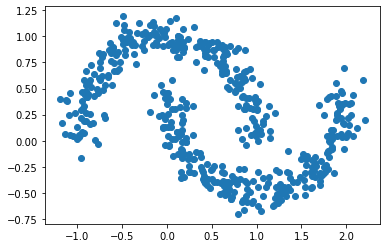

In [68]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

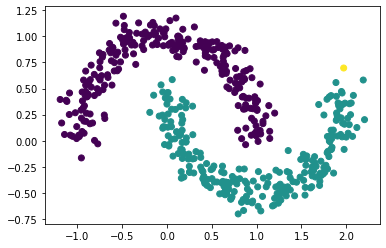

In [69]:
my_clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=my_clusters)
plt.show()

Референс:

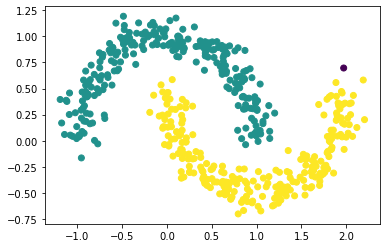

In [70]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [633]:
# вдохновлено https://stackoverflow.com/questions/69853565/extract-coordinates-from-image-to-numpy
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

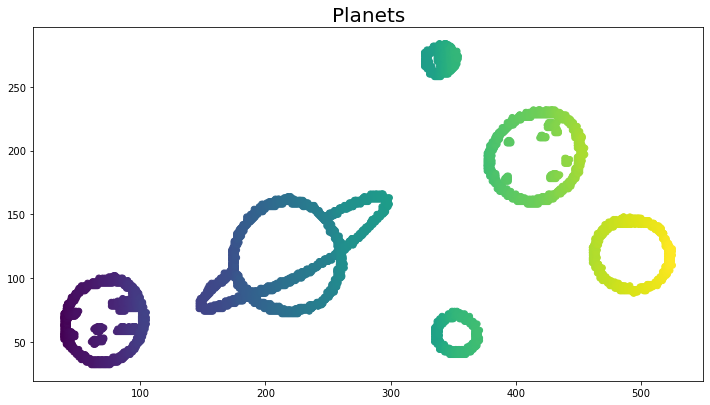

In [657]:
im = plt.imread("my_img.png")
grey = rgb2gray(im)

coordinates = np.argwhere(grey < 0.8)
noise = np.random.randint(2, size=(coordinates.shape[0], coordinates.shape[1]))
noise[::2] = 0

total = coordinates + noise 

min_samples = 1
cls = DBSCAN(min_samples=min_samples)
y = cls.fit_predict(total)
plt.figure(figsize=(12, 6.5))
plt.scatter(total[:, 0], total[:, 1], c=y)
plt.title("Planets", fontsize=20)
plt.show()

In [662]:
eren = plt.imread("/Users/ndosina/Downloads/Снимок экрана 2022-06-18 в 18.12.35.png")
grey = rgb2gray(eren)

coordinates_e = np.argwhere(grey < 0.8)
noise_e = np.random.randint(2, size=(coordinates_e.shape[0], coordinates_e.shape[1]))
noise_e[::2] = 0

total_e = coordinates_e + noise_e

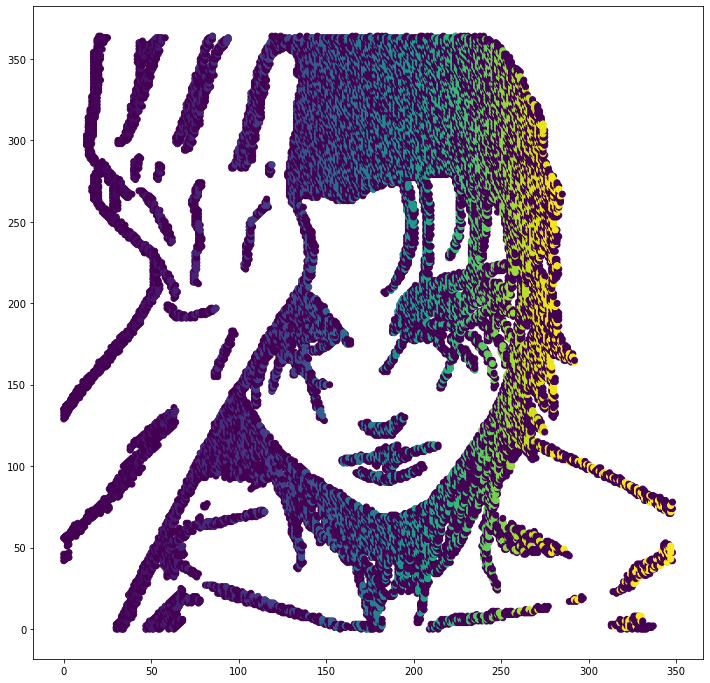

In [664]:
from sklearn.cluster import DBSCAN
min_samples = 2
cls = DBSCAN(min_samples=min_samples)
y = cls.fit_predict(total_e)
plt.figure(figsize=(12, 12))
plt.scatter(total_e[:, 0], total_e[:, 1], c=y)
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [776]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 12.8 ms, sys: 2.34 ms, total: 15.1 ms
Wall time: 12.5 ms


In [778]:
%%time
%%capture
clusters = dbscan_3(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 3.72 s, sys: 58.1 ms, total: 3.78 s
Wall time: 3.72 s


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [428]:
X_train_dbscan = X_train[['Distance', 'DepTime']]
y_train_dbscan = y_train

In [589]:
X_train_part_1, X_valid_1, y_train_part_1, y_valid_1 = train_test_split(X_train_dbscan, y_train_dbscan, test_size=0.3, random_state=20)

In [590]:
wo_cluster_num = CatBoostClassifier(iterations=10)
wo_cluster_num.fit(
    X_train_part_1, y_train_part_1,
    eval_set=(X_valid_1, y_valid_1),
    verbose=False
)
roc_auc_score(y_valid_db, wo_cluster_num.predict_proba(X_valid_db)[:, 1])

0.6990807373758934

In [584]:
pd.DataFrame({'feature_names': X_valid_1.columns, 'feature_importance': wo_cluster_num.get_feature_importance()})\
.sort_values(by=['feature_importance'], ascending=False)

,feature_names,feature_importance
1,DepTime,87.49866
0,Distance,12.50134


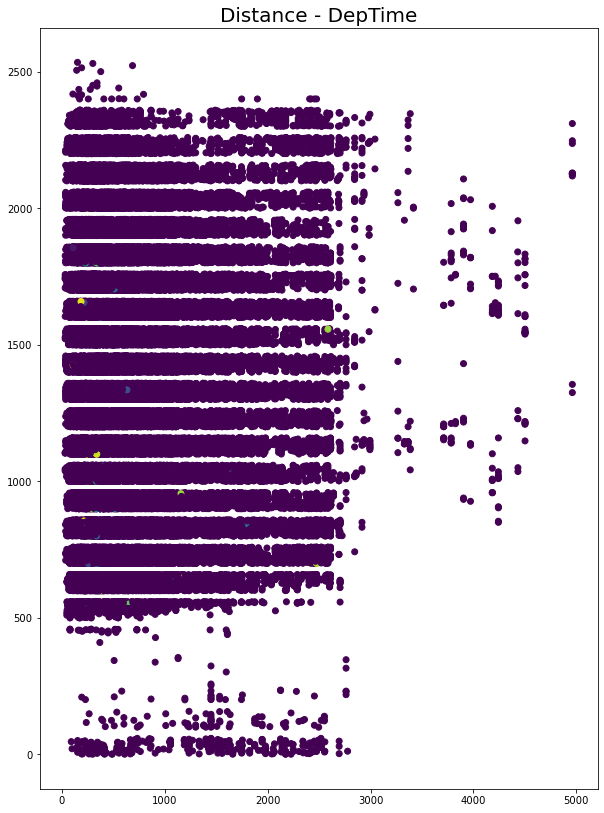

In [549]:
cls = DBSCAN()
clusters = cls.fit_predict(X_train_dbscan)
plt.figure(figsize=(10, 14))
plt.scatter(X_train_dbscan['Distance'], X_train_dbscan['DepTime'], c=clusters)
plt.title("Distance - DepTime", fontsize=20)
plt.show()

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

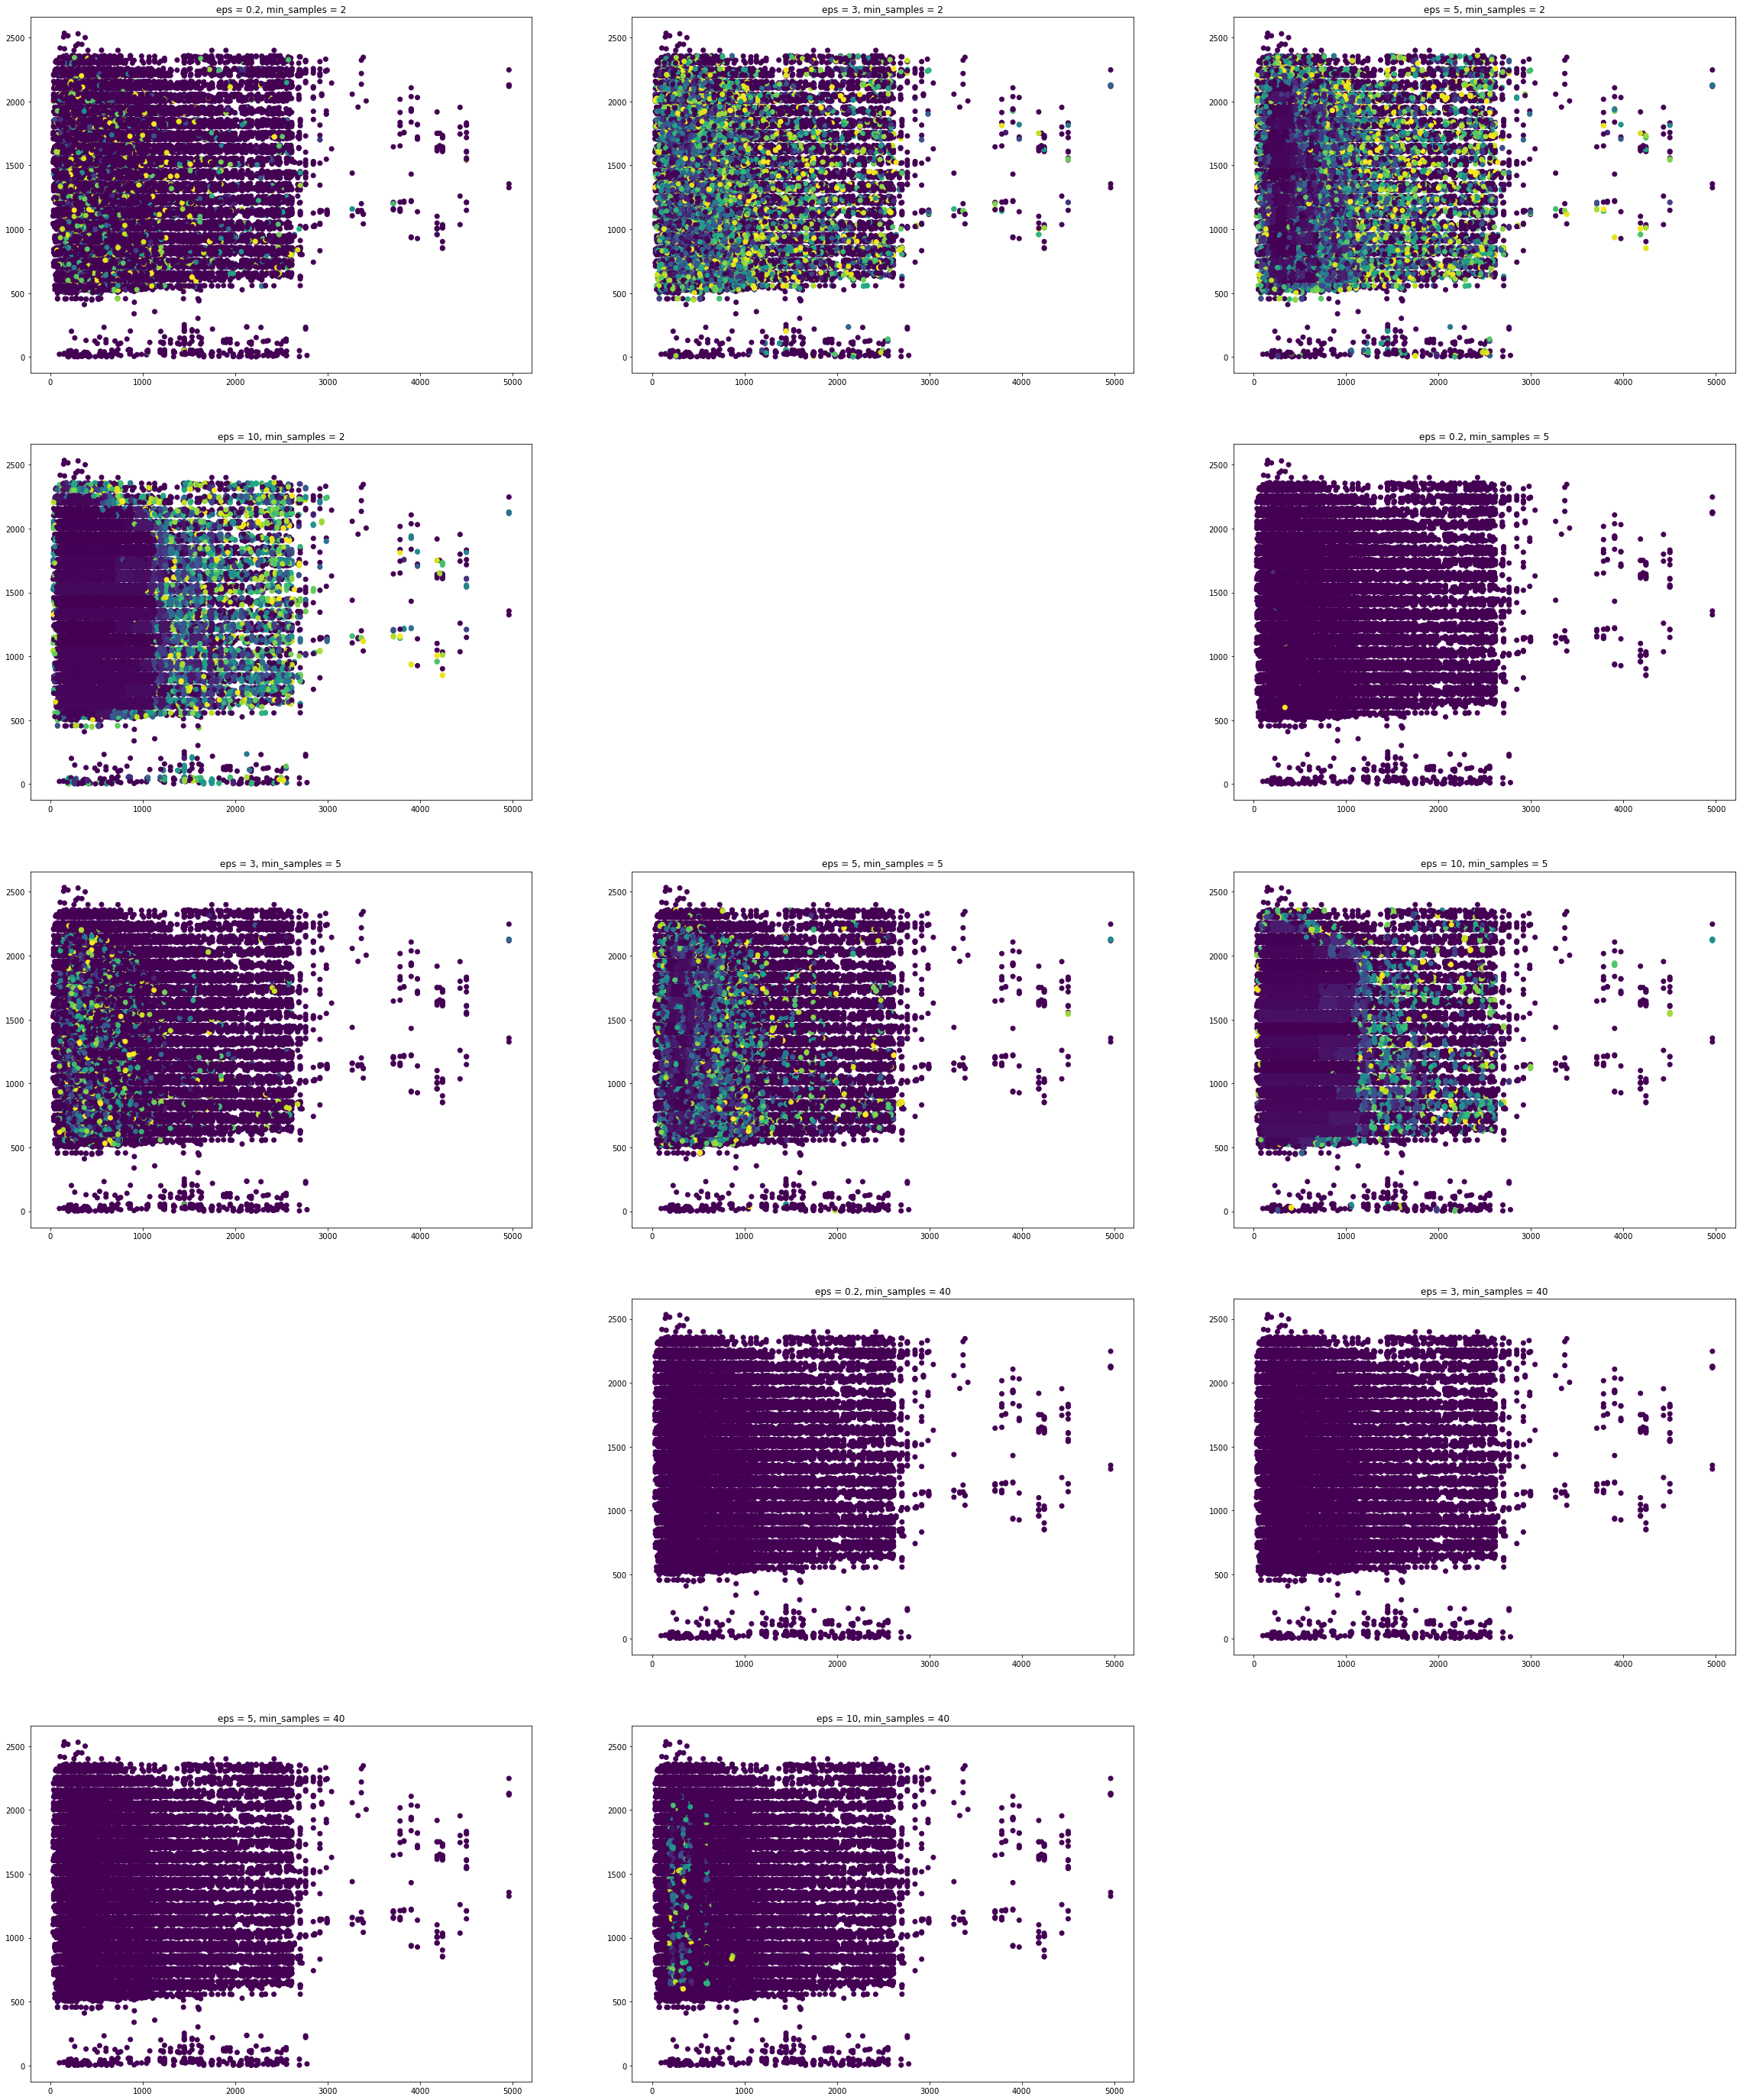

In [407]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆
plt.figure(figsize= (40,60))
i = 1
for samples in [2, 5, 40]:
    for e in [0.2, 3, 5, 10]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X_train_part)
        plt.subplot(6, 3, i)
        plt.scatter(X_train_part['Distance'], X_train_part['DepTime'], c = clusters)
        plt.title('eps = {}, min_samples = {}'.format(e, samples))
        i += 1
    i+=1

plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [595]:
X_train_dbscan_new = pd.concat([X_train_dbscan, pd.DataFrame(map(lambda n: str(n), clusters), columns=['cluster_num'])], axis=1)
y_train_dbscan_new = y_train_dbscan

X_train_part_db, X_valid_db, y_train_part_db, y_valid_db = train_test_split(X_train_dbscan_new, y_train_dbscan_new, test_size=0.3, random_state=20)


In [598]:
with_cluster_num = CatBoostClassifier(iterations=10)
with_cluster_num.fit(
    X_train_part_db, y_train_part_db,
    eval_set=(X_valid_db, y_valid_db),
    cat_features=['cluster_num'],
    verbose=False
)
roc_auc_score(y_valid_db, with_cluster_num.predict_proba(X_valid_db)[:, 1])

0.6957737953289689

In [599]:
pd.DataFrame({'feature_names': X_valid_db.columns, 'feature_importance': with_cluster_num.get_feature_importance()})\
.sort_values(by=['feature_importance'], ascending=False)

,feature_names,feature_importance
1,DepTime,84.160103
0,Distance,14.199239
2,cluster_num,1.640658


__Ответ:__ качество упало на 0.004, это не то чтобы значительно, поэтому в целом можно сказать, что номер кластера не сильно влияет на результат. Возможно, дело в том, что он не дает принципиально новой информации, так как к одинаковым кластерам относятся объекты с "похожими" значениями признаков.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

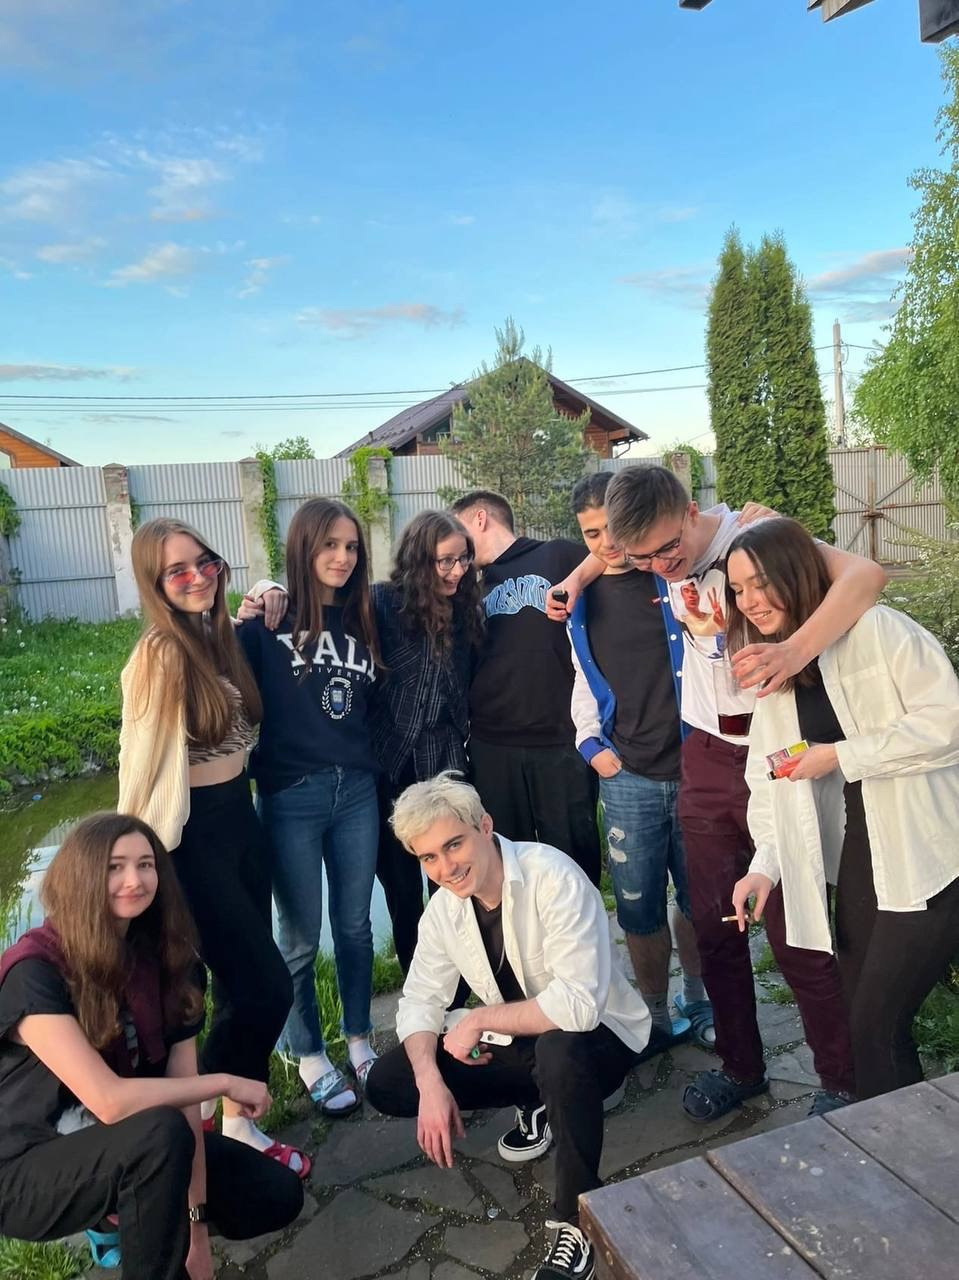

**+0.1 балла** за смешной мем по машинному обучению

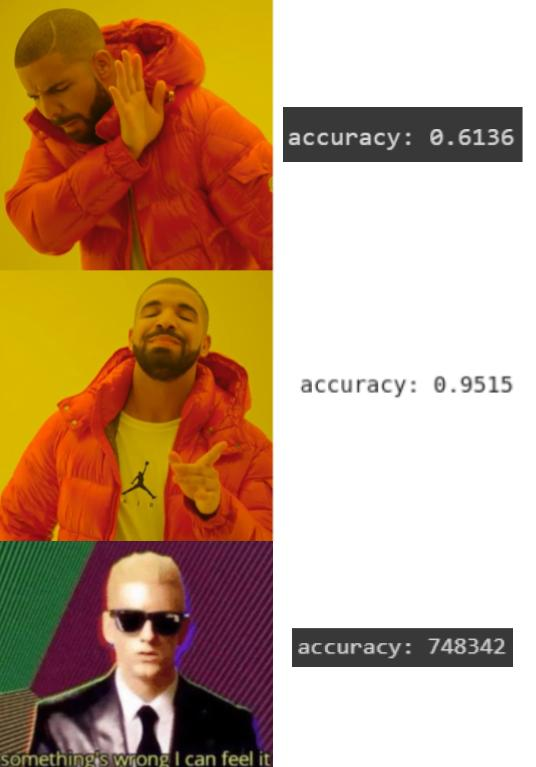

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.